In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp 
from typing import Optional, Union, Dict, List

In [2]:
#==========================================
# Agent-Based Model with Spatial Structure
#==========================================
# Build an Agent Class that can:   
#   Store unique identifier, 2D position (x,y), disease state, and time in current state
#   Calcluate Euclidean distance to other agents
#   Provide readable string representation
#   Lightweight for large populations (10000+ agents)
#   Uses the same valid disease states as compartmental model (S, E1, E2, I1, I2, R1, R2)

class Agent:
    """
    Individual agent in a spatial SEIR epidemic model.
    
    Each agent represents a single individual with a unique identity, spatial position,
    disease state, and temporal tracking of disease progression.
    
    Attributes:
        id (int): Unique identifier for the agent
        x (float): X-coordinate position in 2D space
        y (float): Y-coordinate position in 2D space
        state (str): Current disease state - one of ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']
        time_in_state (float): Duration (in days) the agent has been in current state
    
    The class uses __slots__ for memory efficiency when creating large populations.
    """
    
    # Valid disease states for the two-strain SEIR model
    VALID_STATES = {'S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2'}
    
    # Use __slots__ to reduce memory footprint (important for 10k+ agents)
    __slots__ = ['id', 'x', 'y', 'state', 'time_in_state']
    
    def __init__(self, 
                 id: int, 
                 x: float, 
                 y: float, 
                 state: str = 'S',
                 time_in_state: float = 0.0):
        """
        Initialize an agent with position and disease state.
        
        Parameters:
            id: Unique integer identifier for the agent
            x: X-coordinate position (must be non-negative)
            y: Y-coordinate position (must be non-negative)
            state: Disease state (default: 'S' for susceptible)
            time_in_state: Initial time in current state (default: 0.0 days)
        
        Raises:
            ValueError: If coordinates are negative or state is invalid
        """
        # Validate coordinates
        if x < 0 or y < 0:
            raise ValueError(f"Coordinates must be non-negative. Got x={x}, y={y}")
        
        # Validate disease state
        if state not in self.VALID_STATES:
            raise ValueError(
                f"Invalid disease state '{state}'. Must be one of {self.VALID_STATES}"
            )
        
        # Validate time_in_state
        if time_in_state < 0:
            raise ValueError(f"time_in_state must be non-negative. Got {time_in_state}")
        
        # Initialize attributes
        self.id = id
        self.x = x
        self.y = y
        self.state = state
        self.time_in_state = time_in_state
    
    def distance_to(self, other: 'Agent') -> float:
        """
        Calculate Euclidean distance to another agent.
        
        Parameters:
            other: Another Agent instance
        
        Returns:
            Euclidean distance between this agent and the other agent
        """
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def __repr__(self) -> str:
        """
        Readable string representation for debugging and logging.
        
        Returns:
            String showing agent ID, position, and current state
        """
        return (f"Agent(id={self.id}, pos=({self.x:.1f}, {self.y:.1f}), "
                f"state='{self.state}', t={self.time_in_state:.1f})")
    
    def __str__(self) -> str:
        """
        User-friendly string representation.
        
        Returns:
            Simplified string for display
        """
        return f"Agent #{self.id} [{self.state}] at ({self.x:.1f}, {self.y:.1f})"

In [3]:
#=====================================
# Population Initialization Function
#=====================================
# Functionalities:
#   Create a specified number of agents distributed in 2D space
#   Assign disease states according to a given distribution
#   Position agents spatially with uniform random distribution
#   Ensure reproducibility with random seed control
#   Return a list of Agent objects ready for simulation

def initialize_population(
    n_agents: int,
    space_size: float,
    initial_states: Optional[Dict[str, int]] = None,
    spatial_distribution: str = 'uniform',
    seed: Optional[int] = None
) -> List[Agent]:
    """
    Initialize a population of agents in 2D space.
    
    Creates agents with specified disease state distribution and spatial positions.
    Agent states are shuffled to avoid spatial clustering by disease state.
    
    Parameters:
        n_agents: Total number of agents to create (must be positive)
        space_size: Size of square space (agents positioned in [0, space_size] x [0, space_size])
        initial_states: Dictionary mapping disease states to counts.
                       Example: {'S': 9900, 'E1': 50, 'E2': 50}
                       If None, all agents are susceptible ('S')
                       State counts must sum to n_agents
        spatial_distribution: 'uniform' for uniform random distribution (only option currently)
        seed: Random seed for reproducibility. If None, uses random state.
    
    Returns:
        List of Agent objects with sequential IDs (0 to n_agents-1)
    
    Raises:
        ValueError: If n_agents <= 0, space_size <= 0, state counts don't sum to n_agents,
                   or invalid state names are provided
    
    Examples:
        >>> # Create 100 susceptible agents
        >>> pop = initialize_population(100, 50.0, seed=42)
        
        >>> # Match ODE initial conditions
        >>> pop = initialize_population(
        ...     10000, 100.0, 
        ...     initial_states={'S': 9900, 'E1': 50, 'E2': 50},
        ...     seed=42
        ... )
    """
    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Validate inputs
    if n_agents <= 0:
        raise ValueError(f"n_agents must be positive. Got {n_agents}")
    
    if space_size <= 0:
        raise ValueError(f"space_size must be positive. Got {space_size}")
    
    # Default: all agents susceptible
    if initial_states is None:
        initial_states = {'S': n_agents}
    
    # Validate initial_states
    total_state_count = sum(initial_states.values())
    if total_state_count != n_agents:
        raise ValueError(
            f"Sum of initial_states ({total_state_count}) must equal n_agents ({n_agents})"
        )
    
    # Validate state names
    valid_states = Agent.VALID_STATES
    invalid_states = set(initial_states.keys()) - valid_states
    if invalid_states:
        raise ValueError(
            f"Invalid state names: {invalid_states}. Must be one of {valid_states}"
        )
    
    # Validate spatial_distribution
    if spatial_distribution != 'uniform':
        raise ValueError(
            f"spatial_distribution must be 'uniform'. Got '{spatial_distribution}'"
        )
    
    # Create list of states to assign (before shuffle)
    state_assignments = []
    for state, count in initial_states.items():
        state_assignments.extend([state] * count)
    
    # Shuffle state assignments to avoid clustering
    np.random.shuffle(state_assignments)
    
    # Create agents with shuffled states
    agents = []
    for i in range(n_agents):
        agent = Agent(
            id=i,
            x=np.random.uniform(0, space_size),
            y=np.random.uniform(0, space_size),
            state=state_assignments[i]
        )
        agents.append(agent)
    
    return agents


In [4]:
# How to use the agentic model
# Create individual agents
agent1 = Agent(id=0, x=10.0, y=20.0, state='S')
agent2 = Agent(id=1, x=13.0, y=24.0, state='I1')
agent3 = Agent(id=2, x=50.0, y=50.0, state='E2')

print("Created agents:")
print(agent1)
print(agent2)
print(agent3)

# Calculate distances between agents
dist_12 = agent1.distance_to(agent2)
dist_13 = agent1.distance_to(agent3)

print(f"\nDistance calculations:")
print(f"Agent 0 to Agent 1: {dist_12:.2f} units")
print(f"Agent 0 to Agent 3: {dist_13:.2f} units")

Created agents:
Agent #0 [S] at (10.0, 20.0)
Agent #1 [I1] at (13.0, 24.0)
Agent #2 [E2] at (50.0, 50.0)

Distance calculations:
Agent 0 to Agent 1: 5.00 units
Agent 0 to Agent 3: 50.00 units



Created population of 100 agents

State distribution:
  S: 90
  E1: 5
  E2: 5


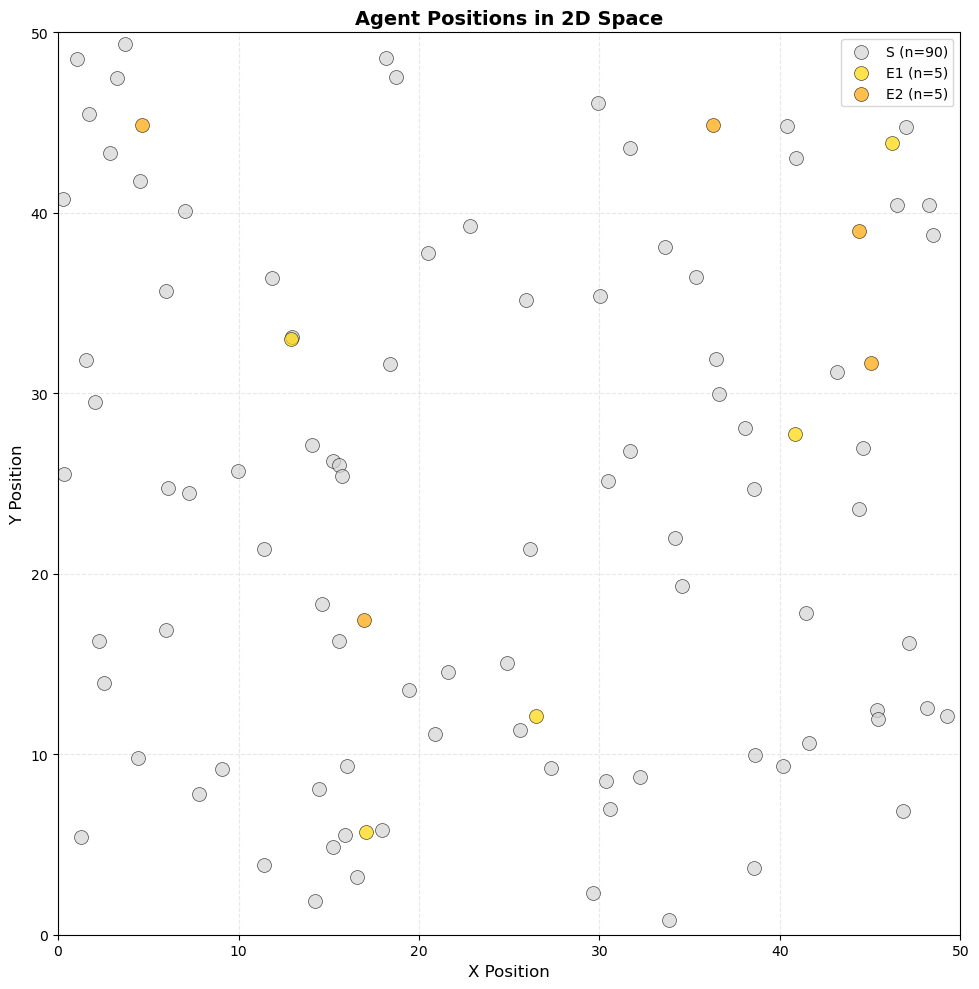

In [5]:
#============================
# Agent Class Example Usage
#============================
# Create a small population
np.random.seed(42)

population = []
n_agents = 100
space_size = 50.0

# Create 90 susceptible, 5 exposed to strain 1, 5 exposed to strain 2
for i in range(90):
    agent = Agent(
        id=i,
        x=np.random.uniform(0, space_size),
        y=np.random.uniform(0, space_size),
        state='S'
    )
    population.append(agent)

for i in range(90, 95):
    agent = Agent(
        id=i,
        x=np.random.uniform(0, space_size),
        y=np.random.uniform(0, space_size),
        state='E1'
    )
    population.append(agent)

for i in range(95, 100):
    agent = Agent(
        id=i,
        x=np.random.uniform(0, space_size),
        y=np.random.uniform(0, space_size),
        state='E2'
    )
    population.append(agent)

# Print population summary
print(f"\nCreated population of {len(population)} agents")
print("\nState distribution:")
for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    count = sum(1 for agent in population if agent.state == state)
    if count > 0:
        print(f"  {state}: {count}")

# Visualize the population in 2D space
state_colors = {
    'S': 'lightgray',
    'E1': 'gold',
    'E2': 'orange',
    'I1': 'red',
    'I2': 'darkred',
    'R1': 'lightblue',
    'R2': 'darkblue'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each state separately for legend
for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    agents_in_state = [agent for agent in population if agent.state == state]
    if agents_in_state:
        x_coords = [agent.x for agent in agents_in_state]
        y_coords = [agent.y for agent in agents_in_state]
        ax.scatter(x_coords, y_coords, 
                  c=state_colors[state], 
                  s=100, 
                  alpha=0.7,
                  edgecolors='black',
                  linewidths=0.5,
                  label=f"{state} (n={len(agents_in_state)})")

ax.set_xlim(0, space_size)
ax.set_ylim(0, space_size)
ax.set_xlabel('X Position', fontsize=12)
ax.set_ylabel('Y Position', fontsize=12)
ax.set_title('Agent Positions in 2D Space', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [6]:
#=====================================
# Population Initialization Examples
#=====================================
# Example 1: Default population (all susceptible)
print("Example 1: Default Population (All Susceptible)")
print("=" * 60)

pop_default = initialize_population(n_agents=100, space_size=50.0, seed=42)

print(f"Created {len(pop_default)} agents")
print(f"First agent: {pop_default[0]}")
print(f"Last agent: {pop_default[-1]}")

# Count states
state_counts = {}
for agent in pop_default:
    state_counts[agent.state] = state_counts.get(agent.state, 0) + 1

print(f"\nState distribution: {state_counts}")
print()

# Example 2: Match ODE initial conditions
print("Example 2: Match ODE Initial Conditions")
print("=" * 60)

initial_states = {'S': 9900, 'E1': 50, 'E2': 50}
pop_ode = initialize_population(
    n_agents=10000,
    space_size=100.0,
    initial_states=initial_states,
    seed=42
)

print(f"Created {len(pop_ode)} agents matching ODE initial conditions")

# Count states
state_counts = {}
for agent in pop_ode:
    state_counts[agent.state] = state_counts.get(agent.state, 0) + 1

print(f"\nState distribution:")
for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    count = state_counts.get(state, 0)
    if count > 0:
        print(f"  {state}: {count:,}")

print(f"\nFirst 5 agents (showing state shuffling):")
for agent in pop_ode[:5]:
    print(f"  {agent}")
print()

Example 1: Default Population (All Susceptible)
Created 100 agents
First agent: Agent #0 [S] at (9.9, 35.6)
Last agent: Agent #99 [S] at (12.8, 30.6)

State distribution: {'S': 100}

Example 2: Match ODE Initial Conditions
Created 10000 agents matching ODE initial conditions

State distribution:
  S: 9,900
  E1: 50
  E2: 50

First 5 agents (showing state shuffling):
  Agent #0 [S] at (78.0, 2.2)
  Agent #1 [S] at (60.0, 69.5)
  Agent #2 [S] at (82.5, 5.6)
  Agent #3 [S] at (48.0, 53.5)
  Agent #4 [S] at (16.9, 32.2)



In [7]:
# Example 3: Reproducibility with seed
print("Example 3: Reproducibility with Seed")
print("=" * 60)

pop_seed1a = initialize_population(n_agents=10, space_size=10.0, seed=123)
pop_seed1b = initialize_population(n_agents=10, space_size=10.0, seed=123)
pop_seed2 = initialize_population(n_agents=10, space_size=10.0, seed=456)

print("Populations with same seed (123):")
print(f"Pop A, Agent 0: x={pop_seed1a[0].x:.4f}, y={pop_seed1a[0].y:.4f}")
print(f"Pop B, Agent 0: x={pop_seed1b[0].x:.4f}, y={pop_seed1b[0].y:.4f}")
print(f"Identical: {pop_seed1a[0].x == pop_seed1b[0].x and pop_seed1a[0].y == pop_seed1b[0].y}")

print(f"\nPopulation with different seed (456):")
print(f"Pop C, Agent 0: x={pop_seed2[0].x:.4f}, y={pop_seed2[0].y:.4f}")
print(f"Different from Pop A: {pop_seed1a[0].x != pop_seed2[0].x or pop_seed1a[0].y != pop_seed2[0].y}")
print()

Example 3: Reproducibility with Seed
Populations with same seed (123):
Pop A, Agent 0: x=4.1092, y=5.7969
Pop B, Agent 0: x=4.1092, y=5.7969
Identical: True

Population with different seed (456):
Pop C, Agent 0: x=4.2801, y=3.3141
Different from Pop A: True



In [8]:
# Example 4: Population with multiple disease states
print("Example 4: Population with Multiple Disease States")
print("=" * 60)

initial_states = {
    'S': 85,
    'E1': 5,
    'E2': 5,
    'I1': 2,
    'I2': 2,
    'R1': 0,
    'R2': 1
}

pop_mixed = initialize_population(
    n_agents=100,
    space_size=50.0,
    initial_states=initial_states,
    seed=42
)

# Count and display states
state_counts = {}
for agent in pop_mixed:
    state_counts[agent.state] = state_counts.get(agent.state, 0) + 1

print(f"Created {len(pop_mixed)} agents with mixed states")
print(f"\nState distribution:")
for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    count = state_counts.get(state, 0)
    if count > 0:
        print(f"  {state}: {count}")

# Show that states are shuffled (not clustered)
print(f"\nFirst 10 agents (demonstrating state shuffling):")
for agent in pop_mixed[:10]:
    print(f"  {agent}")
print()

Example 4: Population with Multiple Disease States
Created 100 agents with mixed states

State distribution:
  S: 85
  E1: 5
  E2: 5
  I1: 2
  I2: 2
  R2: 1

First 10 agents (demonstrating state shuffling):
  Agent #0 [S] at (9.9, 35.6)
  Agent #1 [S] at (39.5, 30.3)
  Agent #2 [S] at (46.3, 32.6)
  Agent #3 [S] at (45.7, 42.5)
  Agent #4 [S] at (22.5, 4.8)
  Agent #5 [S] at (18.5, 33.4)
  Agent #6 [S] at (33.3, 29.6)
  Agent #7 [S] at (13.7, 28.1)
  Agent #8 [S] at (19.1, 48.6)
  Agent #9 [S] at (42.4, 36.1)

